### The correlation between trigger capablity and physical channels - tab. 3

**This approach is based on the fact that every smartapp's trigger capability is correlated with a unique trigger channel**

possible problems:

1. always the trigger capability describe a physical channel? (for capability "number"?)

evolution:

1. save every pair of trigger-action and every smart app description
2. save the cluster of every physical channel
3. extrapolate from smartapp all the trigger and action capabilities and convert them
4. find the correlation between capability and channels


In [1]:
from gensim.models import Word2Vec, KeyedVectors 
import json   # for read the JSON file
import stanza # Official Stanford NLP Python Library for Many Human Languages
import re     # to all lowercase words
import numpy as np

In [2]:
file = open("../../1_Intra_app_Analysis/trigger-action.JSON","r") # read all the capability extrapolated from the apps
trigger_action = json.load(file)
print("tot app analysed:",len(trigger_action.keys()))

tot app analysed: 86


In [3]:
file = open("../../1_Intra_app_Analysis/app-description.JSON","r") # need the desription of the analysed apps
app_description = json.load(file)

In [4]:
# as wrote in the paper "In the end, we check each cluster’s representative keyword and remove
# non-physical-channel related keywords." (cap 4.2 - p 835) so modify cluster_channel and use cluster_channels_FINAL
file = open("../cluster_channels_FINAL.JSON","r") 
dict_channels = json.load(file)
dict_channels

{'temperature': ['air_conditioner',
  'ambient',
  'heater',
  'temp',
  'thermostat',
  'ventilation',
  'temperature'],
 'humidity': ['moisture', 'ventilation', 'humidity'],
 'illumination': ['brightness',
  'bulbs',
  'cameras',
  'candle',
  'colors',
  'light',
  'lighting',
  'switch',
  'switches',
  'lights'],
 'motion': ['action', 'motion', 'speed', 'contacting'],
 'location': ['area', 'hub', 'place', 'location'],
 'smoke': ['fire',
  'heater',
  'leaks',
  'temperature',
  'ventilation',
  'carbon_monoxide'],
 'leakage': ['leaks',
  'lever',
  'sensor',
  'sensors',
  'switches',
  'valve',
  'water',
  'weather',
  'sms'],
 'sound': ['sirens', 'song', 'sound']}

In [5]:
stanza.download('en')       # This downloads the English models for the neural pipeline
nlp = stanza.Pipeline('en') # This sets up a default neural pipeline in English
model = KeyedVectors.load_word2vec_format('../../../../GoogleNews-vectors-negative300.bin', binary=True, limit=100000) # load word2vec pre-trained

2021-10-15 12:04:15 INFO: Downloading default packages for language: en (English)...
2021-10-15 12:04:16 INFO: File exists: /home/volta/stanza_resources/en/default.zip.
2021-10-15 12:04:21 INFO: Finished downloading models and saved to /home/volta/stanza_resources.
2021-10-15 12:04:21 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2021-10-15 12:04:21 INFO: Use device: cpu
2021-10-15 12:04:21 INFO: Loading: tokenize
2021-10-15 12:04:21 INFO: Loading: pos
2021-10-15 12:04:21 INFO: Loading: lemma
2021-10-15 12:04:21 INFO: Loading: depparse
2021-10-15 12:04:21 INFO: Loading: sentiment
2021-10-15 12:04:22 INFO: Loading: constituency
2021-10-15 12:04:22 INFO: Loading: ner
2021-10-15 12:04:23 INFO: Done loading processors!


In [6]:
# analyse every capability

list_all_capabilities = [] # save all different type of capability 

for app in trigger_action.keys():         # for every SmartThings app analysed
    for trigger_cap in trigger_action[app].keys():          # for every trigger channel of that app
            for action in trigger_action[app][trigger_cap]: # for every action 
                action_cap = action[0]
                
                if (not action_cap in list_all_capabilities): # avoid duplicates
                    list_all_capabilities.append(action_cap)

                if (not trigger_cap in list_all_capabilities): # avoid duplicates
                    list_all_capabilities.append(trigger_cap)

                    
print("all capabilities found:", len(list_all_capabilities))
list_all_capabilities.sort()
list_all_capabilities

all capabilities found: 34


['accelerationSensor',
 'alarm',
 'app',
 'beacon',
 'button',
 'carbonMonoxideDetector',
 'colorControl',
 'contactSensor',
 'device.PetFeederShield',
 'device.jawboneUser',
 'doorControl',
 'illuminanceMeasurement',
 'imageCapture',
 'location',
 'locationMode',
 'lock',
 'momentary',
 'motionSensor',
 'musicPlayer',
 'number',
 'powerMeter',
 'presenceSensor',
 'relativeHumidityMeasurement',
 'sendAction',
 'smokeDetector',
 'switch',
 'switchLevel',
 'temperatureMeasurement',
 'thermostat',
 'threeAxis',
 'time',
 'touchSensor',
 'valve',
 'waterSensor']

In [7]:
# function that separate the physical capabilities from the system capabilities
# all physical capabilities are associated with a string that can be processed by word2vec
def cap2string(capability):
    switcher = {
        # physical capabilities 
        'accelerationSensor': "acceleration",
        'beacon': "beacon",
        'carbonMonoxideDetector': "carbon_monoxide",
        'contactSensor': "contact",
        'illuminanceMeasurement':"illumination",
        'location':"location",
        'motionSensor':"motion",
        'musicPlayer': "music player",
        'number': "flash lights",
        'presenceSensor': "presence",
        'relativeHumidityMeasurement': "relative humidity ",
        'smokeDetector': "smoke",
        'switch': "switch",      
        'switchLevel': "switch level",
        'temperatureMeasurement':"temperature",
        'thermostat': "thermostat",
        'threeAxis':"three axis space",
        'valve':"valve",
        'waterSensor':"water sensor",
        
        # system capabilities
#         'alarm': "alarm",
#         'app': "app",
#         'button': "button", # of jawbone headphones
#         'colorControl': "colorControl", # of jawbone headphones or dadicated devices
#         'device.PetFeederShield':"pet feeder shield", # specific device 
#         'device.jawboneUser':"jawbone user", # specific device
#         'doorControl': "door control",
#         'imageCapture': "image capture",
#         'lock':"lock",
#         'locationMode':"locationMode",
#         'momentary': "momentary", # lock or unlock some doors
#         'powerMeter':"powerMeter",
#         'sendAction':"send action",
#         'time':"time",
#         'touchSensor':"touch"
    }
    return switcher.get(capability, f"capabliti not found: {capability}")

list_system_cap = ['alarm','app','button','colorControl','device.PetFeederShield', 
        'device.jawboneUser','doorControl','imageCapture','lock','locationMode',
        'momentary','powerMeter','sendAction','time','touchSensor']

In [8]:
# save the list of all system channels
with open("list_system_cap.JSON","w") as outfile: 
    json.dump(list_system_cap, outfile)

In [9]:
# convert all physical capabilities to set of words that can be correctly processed by word2vec
physical_capabilities = []
for cap in list_all_capabilities:
    if not cap in list_system_cap:
        physical_capabilities.append(cap2string(cap))
    
physical_capabilities # converted capabilities

['acceleration',
 'beacon',
 'carbon_monoxide',
 'contact',
 'illumination',
 'location',
 'motion',
 'music player',
 'flash lights',
 'presence',
 'relative humidity ',
 'smoke',
 'switch',
 'switch level',
 'temperature',
 'thermostat',
 'three axis space',
 'valve',
 'water sensor']

In [10]:
# now correlate every trigger/action capability to its own physical channel
words_pattern = '[a-zA-Z_]+'
cap_to_channel = {"temperature":[], "humidity":[], "illumination":[], "motion":[], "location":[], 
                           "smoke":[], "leakage":[], "sound":[]}

for cap in physical_capabilities: # analyse every physical capability (a capability could have more words inside)
    keywords = [] # keywords found inside app capability
    keywords = re.findall(words_pattern, cap, flags=re.IGNORECASE) # extrapolate the words from the capability
    print(keywords)
    
    clean_keywords = [] # find what words can be really processed by word2vec
    for i in range(len(keywords)):                   # for every keyword exstracted
        try:
            model[keywords[i]]                       # check Word2Vec
            clean_keywords.append(keywords[i])       # if can apply word2vec save it
        except KeyError as err:
            print("handling Error: ", err)           # some words can not be processed by Word2Vec

    print(cap,"-", clean_keywords)        

    similarity_list = {} # list made by [physical channel]: level of similarity
    if len(clean_keywords) == 0: # case there aren't any words inside the capability 
        print(f"!!error check the conversion function!!")

    else:
            if len(clean_keywords) == 1: # case there are only 1 keyword inside capability
                for key in dict_channels.keys(): # check for every physical channel
                    similarity_temp = 0
                    for channel_NN in dict_channels[key]: # for every keyword inside the channel cluster
                        similarity_temp += model.similarity(clean_keywords[0],channel_NN)
                    # divide by the number of cluster keywords --> result: the mean of similarity
                    similarity_list[key] = (similarity_temp/len(dict_channels[key]))*100

            else: # case there are more than 1 keyword inside the capability
                for key in dict_channels.keys(): # check for every physical channel
                    similarity_partial = 0
                    for keyword in clean_keywords: # for every keyword NN extracted from description
                        similarity_temp = 0
                        for channel_NN in dict_channels[key]:  # for every keyword inside the channel cluster
                            #print(keyword,channel_NN,"\t", model.similarity(keyword,channel_NN))
                            similarity_temp += model.similarity(keyword,channel_NN)
                         # divide by the number of cluster keywords --> result: the mean of similarity (given by only 1 NN)
                        similarity_temp = similarity_temp/len(dict_channels[key])
                        similarity_partial += similarity_temp
                    #print("this keyword for ",key,"has got a level", similarity_partial/len(clean_keywords))
                    similarity_list[key] = (similarity_partial/len(clean_keywords))*100

            print(similarity_list)
            # now find the highest physical channel associated
            channel_association = ""
            max_value = 0
            for channel in similarity_list.keys():
                if similarity_list[channel] > max_value:
                    max_value = similarity_list[channel]
                    channel_association = channel

            print("most similar:", channel_association, max_value, "\n")
            cap_to_channel[channel_association].append(cap)

cap_to_channel

['acceleration']
acceleration - ['acceleration']
{'temperature': 12.674963900021144, 'humidity': 11.768864840269089, 'illumination': 10.116687174886465, 'motion': 20.73199264705181, 'location': 3.6133638117462397, 'smoke': 11.38808336108923, 'leakage': 16.760574653744698, 'sound': 5.993366117278734}
most similar: motion 20.73199264705181 

['beacon']
beacon - ['beacon']
{'temperature': 7.566695514002017, 'humidity': 4.8923226073384285, 'illumination': 21.361069008708, 'motion': 2.6424705516546965, 'location': 18.30311417579651, 'smoke': 8.678069462378819, 'leakage': 12.829999832643402, 'sound': 17.57648686567942}
most similar: illumination 21.361069008708 

['carbon_monoxide']
carbon_monoxide - ['carbon_monoxide']
{'temperature': 35.156890749931335, 'humidity': 40.984738866488144, 'illumination': 13.85080773383379, 'motion': 7.697823783382773, 'location': 4.6054113656282425, 'smoke': 49.541254838307694, 'leakage': 16.78143818345335, 'sound': 13.188401361306509}
most similar: smoke 49.5

{'temperature': ['thermostat'],
 'humidity': ['relative humidity ', 'temperature'],
 'illumination': ['beacon',
  'illumination',
  'flash lights',
  'switch',
  'switch level'],
 'motion': ['acceleration', 'contact', 'motion'],
 'location': ['location', 'presence', 'three axis space'],
 'smoke': ['carbon_monoxide', 'smoke'],
 'leakage': ['valve', 'water sensor'],
 'sound': ['music player']}

In [11]:
# final creation of table 3, p.839
cap_to_channel

{'temperature': ['thermostat'],
 'humidity': ['relative humidity ', 'temperature'],
 'illumination': ['beacon',
  'illumination',
  'flash lights',
  'switch',
  'switch level'],
 'motion': ['acceleration', 'contact', 'motion'],
 'location': ['location', 'presence', 'three axis space'],
 'smoke': ['carbon_monoxide', 'smoke'],
 'leakage': ['valve', 'water sensor'],
 'sound': ['music player']}

In [122]:
# now classify the switch capability based on app description
# the cap switch is correlated to different appliances like fan, bulb or air_conditioner
# so there are three types of switch: switch_humidity, switch_illumination and switch_temperature
similarity_list = {}
POS_accepted = ["NN", "NNS"]  # part of speech tags accepted 
trigger_action_translated = []

for app in trigger_action.keys(): # for every app where I can extrapolate info
    for trigger_cap in trigger_action[app].keys(): # for every app trigger capability
        for actions in trigger_action[app][trigger_cap]: # for every action correlated to that trigger capability
            # check if the action capability is a switch
            pair = [] # pair of trigger-action capability
            action_cap = actions[0]
            if action_cap == "switch":
                # have to save pair like trigger-action -> process the trigger capability
                if not trigger_cap in list_system_cap: # if processed a capability related to physical channel
                    string_trigger_capability = cap2string(trigger_cap) # convert it 
                    pair.append(string_trigger_capability)
                else:
                    pair.append(trigger_cap) # else save directly
                
                # now process the action capability
                print("found:",app, " use ", action_cap )
                description = nlp(app_description[app]) # now classify the switch capability based on app description
                keywords = []
                clean_keywords = []
                for sent in description.sentences: 
                    for word in sent.words:           # check each word of the description
                        if word.xpos in POS_accepted: # check is it is a NN or NNS
                            keywords_found = word.text.lower()
                            if not keywords_found in keywords:  # if not already saved that keyword 
                                keywords.append(keywords_found) # save it
    
                for i in range(len(keywords)): # for every keywords saved from the description 
                    try:
                        word = str(keywords[i])
                        if len(word) > 1: # if it is not a single letter or symbol
                            model[word]   # try to apply Word2Vec
                            clean_keywords.append(word)
                        else:
                            print("word not processed: ",word)
                    except KeyError as err:
                        print("handling Error: ", err) # some words can not be processed by Word2Vec

                print(clean_keywords)
                
                if len(clean_keywords) == 0: # case there aren't any NN keyword inside that app description (strange)
                    print(f"!!error!!")

                else:
                    if len(clean_keywords) == 1: # case there are only 1 keyword inside app description
                        for phy_ch in ['temperature', 'humidity', 'illumination']:
                            similarity_temp = 0
                            for channel_NN in dict_channels[phy_ch]: # for every keyword inside the channel cluster
                                similarity_temp += model.similarity(clean_keywords[0],channel_NN)
                            # divide by the number of cluster keywords --> result: the mean of similarity
                            similarity_list[phy_ch] = (similarity_temp/len(dict_channels[phy_ch]))*100

                    else: # case there are more than 1 keyword inside tcapability
                        for phy_ch in ['temperature', 'humidity', 'illumination']:
                            similarity_partial = 0
                            for keyword in clean_keywords: # for every keyword NN extracted from description
                                similarity_temp = 0
                                for channel_NN in dict_channels[phy_ch]:  # for every keyword inside the channel cluster
                                    #print(keyword,channel_NN,"\t", model.similarity(keyword,channel_NN))
                                    similarity_temp += model.similarity(keyword,channel_NN)
                                 # divide by the number of cluster keywords --> result: the mean of similarity (given by only 1 NN)
                                similarity_temp = similarity_temp/len(dict_channels[phy_ch])
                                similarity_partial += similarity_temp
                            #print("this keyword for ",key,"has got a level", similarity_partial/len(clean_keywords))
                            similarity_list[phy_ch] = (similarity_partial/len(clean_keywords))*100

                    #print(similarity_list)
                    # now find the highest physical channel association 
                    channel_association = ""
                    max_value = 0
                    for channel in similarity_list.keys():
                        if (similarity_list[channel] > max_value):
                            max_value = similarity_list[channel]
                            channel_association = channel

                    print("most similar:", channel_association, max_value)
                    
                    if channel_association == "temperature":
                        pair.append("switch air_conditioner") # switch AC
                    
                    elif channel_association == "humidity":
                        pair.append("switch vent") # switch vent
                    else:
                        pair.append("switch bulb") # switch bulb
                
                
            else: # this code manages the case in which the action capability is not a switch one
                # process the trigger cap
                if not trigger_cap in list_system_cap:
                    string_trigger_capability = cap2string(trigger_cap)
                    pair.append(string_trigger_capability)
                else:
                    pair.append(trigger_cap)
                # process the action cap
                if not action_cap in list_system_cap:
                    string_action_capability = cap2string(action_cap)
                    pair.append(string_action_capability)
                else:
                    pair.append(action_cap)
                
            # in the end save the pair 
            print(app,"\t", pair, "\n")
            trigger_action_translated.append(pair)

trigger_action_translated.sort()

with open("all_translated_pair_trigger-action.JSON","w") as outfile: # save the result
    json.dump(trigger_action_translated, outfile)
            
trigger_action_translated

found: beacon-control  use  switch
['home', 'phrase', 'lights', 'door', 'region']
most similar: illumination 14.02022996544838
beacon-control 	 ['beacon', 'switch bulb'] 

found: beacon-control  use  switch
['home', 'phrase', 'lights', 'door', 'region']
most similar: illumination 14.02022996544838
beacon-control 	 ['beacon', 'switch bulb'] 

beacon-control 	 ['beacon', 'lock'] 

found: beacon-control  use  switch
['home', 'phrase', 'lights', 'door', 'region']
most similar: illumination 14.02022996544838
beacon-control 	 ['beacon', 'switch bulb'] 

found: beacon-control  use  switch
['home', 'phrase', 'lights', 'door', 'region']
most similar: illumination 14.02022996544838
beacon-control 	 ['beacon', 'switch bulb'] 

beacon-control 	 ['beacon', 'lock'] 

found: big-turn-off  use  switch
['lights']
most similar: illumination 49.93536561727524
big-turn-off 	 ['location', 'switch bulb'] 

found: big-turn-off  use  switch
['lights']
most similar: illumination 49.93536561727524
big-turn-off 

['message', 'light', 'laundry']
most similar: illumination 19.292593002319336
laundry-monitor 	 ['acceleration', 'switch bulb'] 

left-it-open 	 ['contact', 'sendAction'] 

left-it-open 	 ['contact', 'sendAction'] 

left-it-open 	 ['contact', 'sendAction'] 

found: let-there-be-dark  use  switch
['lights', 'contact', 'sensor']
most similar: illumination 26.81697643051545
let-there-be-dark 	 ['contact', 'switch bulb'] 

found: let-there-be-dark  use  switch
['lights', 'contact', 'sensor']
most similar: illumination 26.81697643051545
let-there-be-dark 	 ['contact', 'switch bulb'] 

found: let-there-be-dark  use  switch
['lights', 'contact', 'sensor']
most similar: illumination 26.81697643051545
let-there-be-dark 	 ['contact', 'switch bulb'] 

found: let-there-be-light  use  switch
['lights', 'multi']
most similar: illumination 29.560739398002628
let-there-be-light 	 ['contact', 'switch bulb'] 

found: let-there-be-light  use  switch
['lights', 'multi']
most similar: illumination 29.56073

handling Error:  "Key 'humidifier' not present"
['humidity', 'sensor']
most similar: humidity 47.88095752398173
smart-humidifier 	 ['relative humidity ', 'switch vent'] 

found: smart-humidifier  use  switch
handling Error:  "Key 'humidifier' not present"
['humidity', 'sensor']
most similar: humidity 47.88095752398173
smart-humidifier 	 ['relative humidity ', 'switch vent'] 

found: smart-nightlight  use  switch
['lights', 'motion', 'light', 'time']
most similar: illumination 28.07584679685533
smart-nightlight 	 ['motion', 'switch bulb'] 

found: smart-nightlight  use  switch
['lights', 'motion', 'light', 'time']
most similar: illumination 28.07584679685533
smart-nightlight 	 ['motion', 'switch bulb'] 

smart-security 	 ['motion', 'sendAction'] 

smart-security 	 ['motion', 'locationMode'] 

smart-security 	 ['motion', 'alarm'] 

smart-security 	 ['motion', 'sendAction'] 

smart-security 	 ['motion', 'sendAction'] 

smart-security 	 ['motion', 'alarm'] 

smart-security 	 ['contact', 's

[['acceleration', 'colorControl'],
 ['acceleration', 'colorControl'],
 ['acceleration', 'flash lights'],
 ['acceleration', 'imageCapture'],
 ['acceleration', 'momentary'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'sendAction'],
 ['acceleration', 'switch bulb'],
 ['alarm', 'alarm'],
 ['app', 'alarm'],
 ['app', 'colorControl'],
 ['app', 'colorControl'],
 ['app', 'doorControl'],
 ['app', 'lock'],
 ['app', 'lock'],
 ['app', 'switch air_conditioner'],
 ['app', 'switch bulb'],
 ['app', 'switch bulb'],
 ['app', 'switch bulb'],
 ['app', 'switch bulb'],
 ['app', 'thermostat'],
 ['app', 'thermosta

In [109]:
print("total pair trigger-action of system+physical channels:",len(trigger_action_translated))

total pair trigger-action of system+physical channels: 294


In [119]:
# obviously add the switch dedicated to its own physical channel
if not "switch air_conditioner" in cap_to_channel["temperature"]:
    cap_to_channel["temperature"].append("switch air_conditioner")
    
if not "switch vent" in cap_to_channel["humidity"]:    
    cap_to_channel["humidity"].append("switch vent")
    
if not "switch bulb" in cap_to_channel["illumination"]:      
    cap_to_channel["illumination"].append("switch bulb")

with open("set_of_capability_related_channels.JSON","w") as outfile: # save the result
    json.dump(cap_to_channel, outfile)

cap_to_channel

{'temperature': ['thermostat', 'switch air_conditioner'],
 'humidity': ['relative humidity ', 'temperature', 'switch vent'],
 'illumination': ['beacon',
  'illumination',
  'flash lights',
  'switch',
  'switch level',
  'switch bulb'],
 'motion': ['acceleration', 'contact', 'motion'],
 'location': ['location', 'presence', 'three axis space'],
 'smoke': ['carbon_monoxide', 'smoke'],
 'leakage': ['valve', 'water sensor'],
 'sound': ['music player']}

## the analysis of trigger-capability and action-capability

follow 2 ways:
* about physical channels
* about system channels

In [127]:
phy_dict_actions_related={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[], "sound":[]}

phy_dict_trigger_related={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[], "sound":[]}

sys_dict_actions_related={'alarm':[],'app':[],'button':[],'colorControl':[],'device.PetFeederShield':[], 
        'device.jawboneUser':[],'doorControl':[],'imageCapture':[],'lock':[],'locationMode':[],
        'momentary':[],'powerMeter':[],'sendAction':[],'time':[],'touchSensor':[]}

sys_dict_trigger_related={'alarm':[],'app':[],'button':[],'colorControl':[],'device.PetFeederShield':[], 
        'device.jawboneUser':[],'doorControl':[],'imageCapture':[],'lock':[],'locationMode':[],
        'momentary':[],'powerMeter':[],'sendAction':[],'time':[],'touchSensor':[]}

for pair in trigger_action_translated: # check every trigger-action pair of system+physical channels
        trigger_cap = pair[0]
        action_cap = pair[1]
        # save all trigger capability
        if not trigger_cap in list_system_cap: # if trigger cap is about a physical channel
            for phy_channel in phy_dict_trigger_related.keys(): # for every physical channel
                if trigger_cap in cap_to_channel[phy_channel]: # find if there is that trigger capability
                    #print(trigger_cap, " in ", phy_channel)
                    phy_dict_trigger_related[phy_channel].append(trigger_cap) # and save the trigger capability
        else:
            sys_dict_trigger_related[trigger_cap].append(trigger_cap) # if trigger cap is about a system channel
            
        # save all action capability
        if not action_cap in list_system_cap:  # if action cap is about a physical channel
            for phy_channel in phy_dict_actions_related.keys(): # for every channel
                if action_cap in cap_to_channel[phy_channel]: # find if there is that action capability
                    phy_dict_actions_related[phy_channel].append(action_cap) # if there is save the trigger capability
        else:
            sys_dict_actions_related[action_cap].append(action_cap) # if action cap is about a system channel


In [112]:
# physical trigger capabilities analysis 
phy_trigger_related = []
for key in phy_dict_trigger_related.keys():
    phy_trigger_related.append(len(phy_dict_trigger_related[key]))
phy_trigger_related = np.array(phy_trigger_related)
phy_trigger_related

array([  5,  23,  25,  50, 109,   7,  11,   0])

In [113]:
# physical action capabilities analysis 
phy_actions_related = []
for key in phy_dict_actions_related.keys():
    phy_actions_related.append(len(phy_dict_actions_related[key]))
phy_actions_related = np.array(phy_actions_related)
phy_actions_related

array([39,  7, 52,  0,  0,  0,  1,  4])

In [114]:
# system trigger capabilities analysis 
sys_trigger_related = []
for key in sys_dict_trigger_related.keys():
    sys_trigger_related.append(len(sys_dict_trigger_related[key]))
sys_trigger_related = np.array(sys_trigger_related)
sys_trigger_related

array([ 1, 15, 10,  0,  0,  8,  0,  0,  0,  0,  0,  4,  0, 23,  3])

In [115]:
# system action capabilities analysis 
sys_actions_related = []
for key in sys_dict_actions_related.keys():
    sys_actions_related.append(len(sys_dict_actions_related[key]))
sys_actions_related = np.array(sys_actions_related)
sys_actions_related

array([  8,   0,   0,  26,   1,   0,   2,   5,  10,   9,   3,   0, 127,
         0,   0])

<ipython-input-124-1ef6dd26ce6d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels( phy_labels, rotation=45 )
<ipython-input-124-1ef6dd26ce6d>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels( sys_labels, rotation=45 )


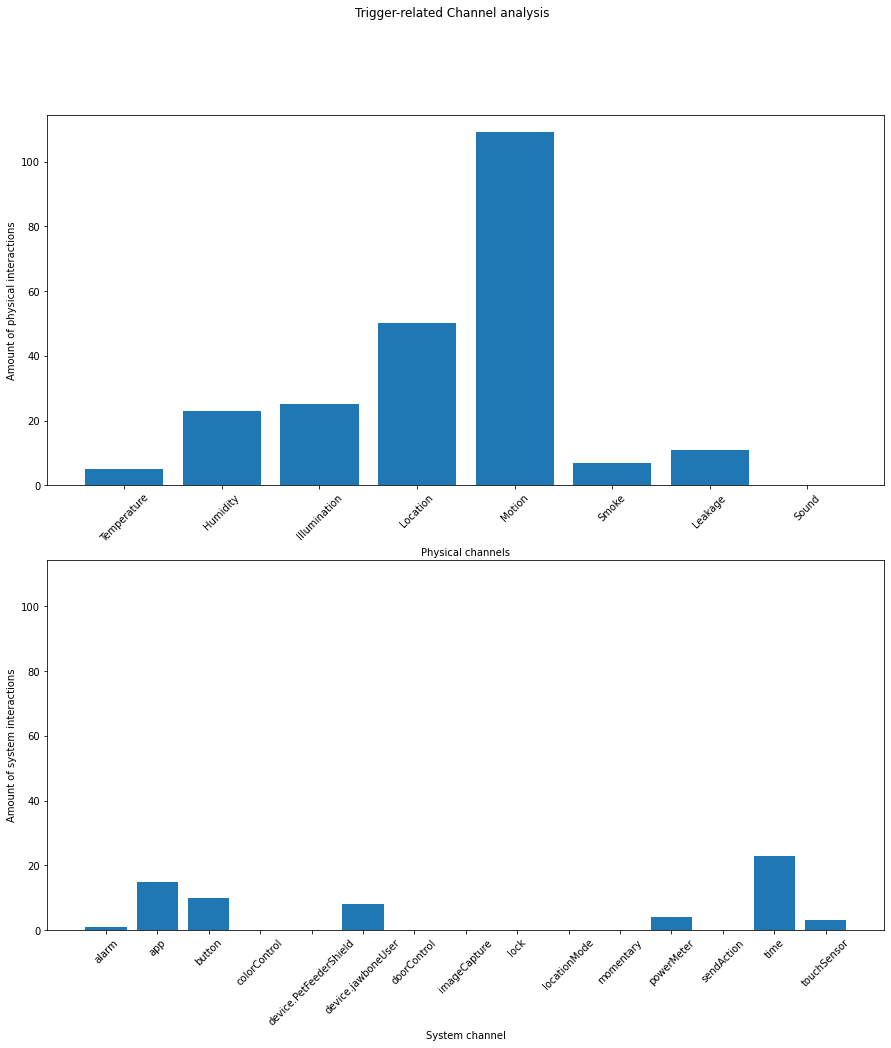

In [124]:
import matplotlib.pyplot as plt

phy_labels = ["Temperature","Humidity", "Illumination", "Location", "Motion", "Smoke", "Leakage", "Sound"]
sys_labels = list_system_cap

phy_x_pos = np.arange(len(phy_x))
sys_x_pos = np.arange(len(sys_x))


fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharey=True)
fig.suptitle('Trigger-related Channel analysis')

axs[0].bar(phy_labels, phy_trigger_related, align='center')
axs[0].set_xticklabels( phy_labels, rotation=45 )
axs[0].set_ylabel('Amount of physical interactions')
axs[0].set_xlabel('Physical channels')

axs[1].bar(sys_labels, sys_trigger_related, align='center')
axs[1].set_xticklabels( sys_labels, rotation=45 )
axs[1].set_ylabel('Amount of system interactions')
axs[1].set_xlabel('System channel')

plt.show()

<ipython-input-126-6a5dd7191008>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels( phy_labels, rotation=45 )
<ipython-input-126-6a5dd7191008>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels( sys_labels, rotation=45 )


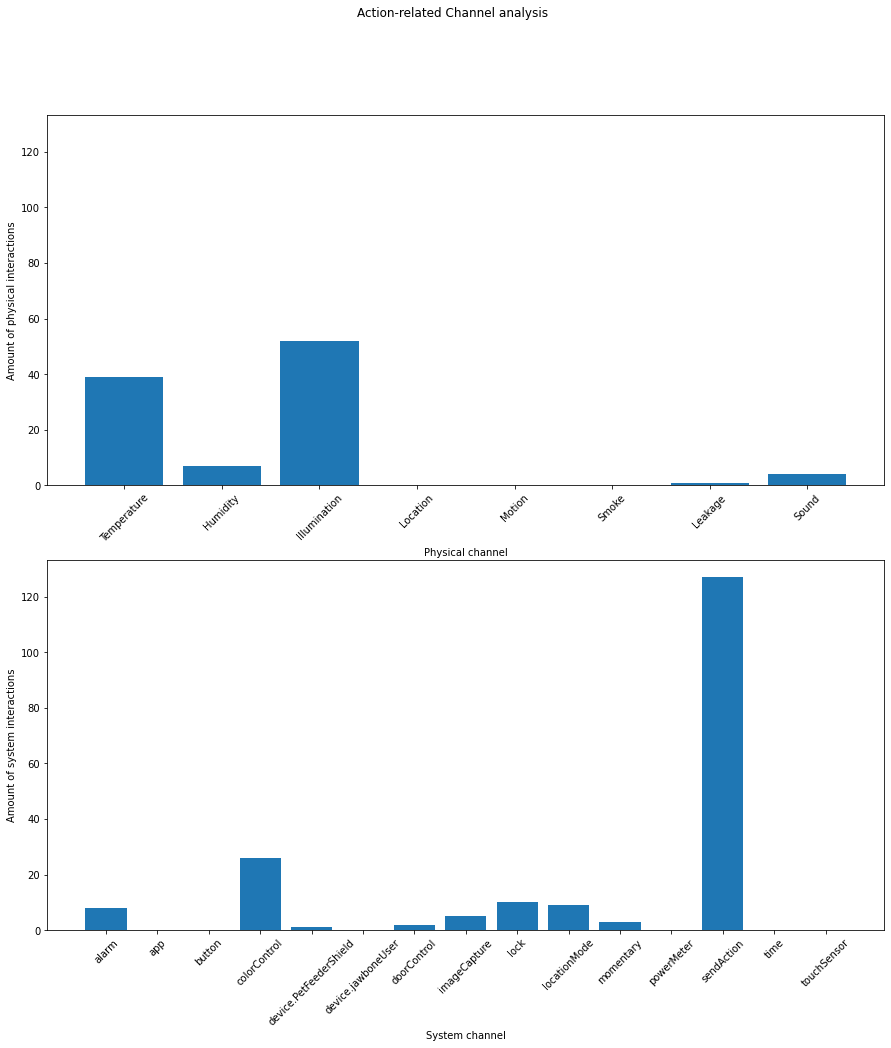

In [126]:
phy_labels = ["Temperature","Humidity", "Illumination", "Location", "Motion", "Smoke", "Leakage", "Sound"]
sys_labels = list_system_cap

phy_x_pos = np.arange(len(phy_x))
sys_x_pos = np.arange(len(sys_x))


fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharey=True)
fig.suptitle('Action-related Channel analysis')

axs[0].bar(phy_labels, phy_actions_related, align='center')
axs[0].set_xticklabels( phy_labels, rotation=45 )
axs[0].set_ylabel('Amount of physical interactions')
axs[0].set_xlabel('Physical channel')

axs[1].bar(sys_labels, sys_actions_related, align='center')
axs[1].set_xticklabels( sys_labels, rotation=45 )
axs[1].set_ylabel('Amount of system interactions')
axs[1].set_xlabel('System channel')

plt.show()